In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
cases = pd.read_csv("confirmed_cases_table2_age_group.csv")

In [3]:
case_nums = cases.groupby(by = 'notification_date', as_index = False).size()

In [4]:
case_nums

,notification_date,size
0,2021-06-29,31
1,2021-06-30,31
2,2021-07-01,31
3,2021-07-02,42
4,2021-07-03,24
...,...,...
102,2021-10-09,506
103,2021-10-10,444
104,2021-10-11,373
105,2021-10-12,439


In [5]:
case_nums['smooth'] = [0]*len(case_nums)
for i in range(0,len(case_nums)-7):
    case_nums['smooth'][i+7] = (case_nums['size'][i]+case_nums['size'][i+1]+case_nums['size'][i+2]+case_nums['size'][i+3]+case_nums['size'][i+4]+case_nums['size'][i+5]+case_nums['size'][i+6])/7

<ipython-input-5-ebca10bbeaa1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_nums['smooth'][i+7] = (case_nums['size'][i]+case_nums['size'][i+1]+case_nums['size'][i+2]+case_nums['size'][i+3]+case_nums['size'][i+4]+case_nums['size'][i+5]+case_nums['size'][i+6])/7


In [6]:
case_nums.set_index('notification_date',inplace=True)

<AxesSubplot:xlabel='notification_date'>

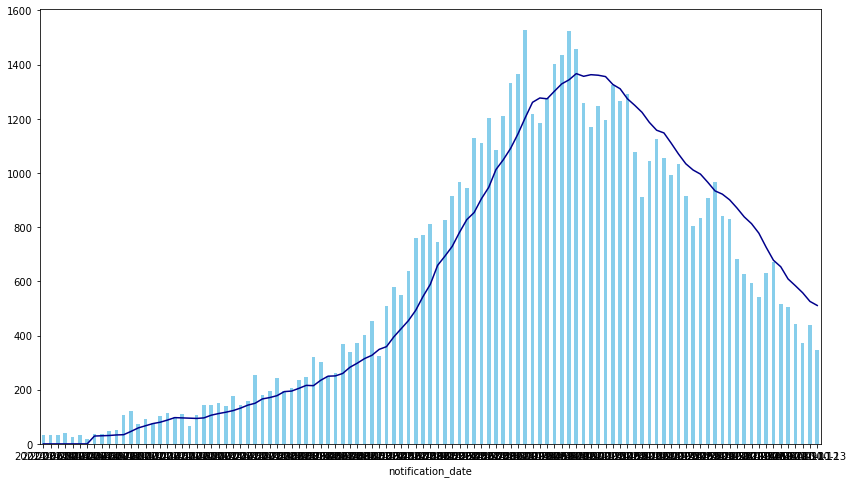

In [7]:
case_nums['size'].plot.bar(
    figsize = [14,8],
    color = 'skyblue'
)
case_nums['smooth'].plot(
    color = 'darkblue'
)

In [8]:
hosp = pd.read_csv("hospNSW.csv",parse_dates=True)
#hosp.dropna(inplace=True)

In [9]:
hosp['DATE'] = hosp['DATE'].astype('datetime64')
hosp.sort_values('DATE',inplace=True)
hosp['HOSP'] = hosp['HOSP'].str.replace(',','')
hosp[['HOSP']] = hosp[['HOSP']].astype('int')
                
hosp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 126 to 0
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    127 non-null    datetime64[ns]
 1   HOSP    127 non-null    int32         
 2   ICU     127 non-null    int64         
 3   VENT    127 non-null    int64         
dtypes: datetime64[ns](1), int32(1), int64(2)
memory usage: 4.5 KB


<AxesSubplot:xlabel='DATE'>

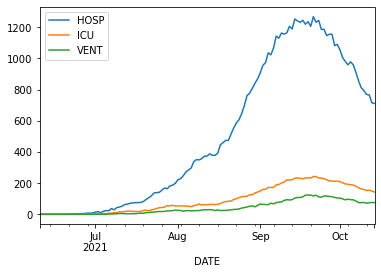

In [10]:
hosp.plot(
    x = 'DATE',
    y = ['HOSP','ICU','VENT']
)

In [11]:
vax1 = pd.read_csv("At least 1 dose.csv")#,parse_dates=True)
vax2 = pd.read_csv("2 Doses.csv")#,parse_dates=True)

In [12]:
vax = pd.merge(vax1,vax2,how='outer',on='Unnamed: 0')
vax = vax[['Unnamed: 0','NSW_x','NSW_y']]
vax.rename(columns={'Unnamed: 0': 'DATE','NSW_x': 'ONE_DOSE','NSW_y': 'TWO_DOSES'}, inplace=True)
#vax = vax.fillna(0)


In [13]:
vax['DATE']="2021-"+vax['DATE'].str.slice(start=-2)+"-"+vax['DATE'].str.slice(stop=2)
vax['DATE']=vax['DATE'].astype('datetime64')

In [14]:
vax.tail()

,DATE,ONE_DOSE,TWO_DOSES
231,2021-10-10,5931034,4827636.0
232,2021-10-11,5938082,4856736.0
233,2021-10-12,5959853,4939216.0
234,2021-10-13,5981468,5025898.0
235,2021-10-14,6000795,5105834.0


In [15]:
# The index assumes one dose is 40% effective and two are 80% effective
vax['VAX_INDEX'] = (vax['ONE_DOSE'] + vax['TWO_DOSES']*2)/-3

<AxesSubplot:xlabel='DATE'>

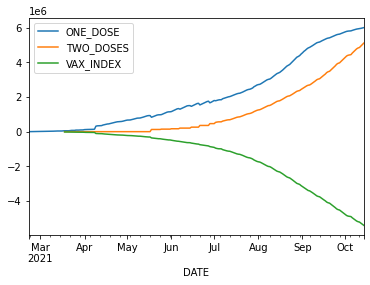

In [16]:
vax.plot(
    x = 'DATE'   
)

In [17]:
cases = case_nums.reset_index()
cases["notification_date"] = cases["notification_date"].astype('datetime64')
cases = cases.rename(columns={"notification_date":"DATE","size":"CASES","smooth":"AVG_CASES"})
cases.head()

,DATE,CASES,AVG_CASES
0,2021-06-29,31,0
1,2021-06-30,31,0
2,2021-07-01,31,0
3,2021-07-02,42,0
4,2021-07-03,24,0


In [18]:
# Lag times as per Mike Honey
d_death = dt.timedelta(days=-20)
d_vent = dt.timedelta(days=-10)
d_ICU = dt.timedelta(days=-8)
d_hosp = dt.timedelta(days=-5)

In [19]:
deaths = pd.read_csv("deaths_daily_state.csv",parse_dates=True)
deaths = deaths[["Date","NSW"]]
#deaths["Date"] = "2021-"+deaths["Date"].str.slice(2,5)+"-"+deaths["Date"].str.slice(stop=2)
#deaths["Date"]=deaths["Date"].astype('datetime64')
deaths["Date"] = deaths["Date"].str.replace("/","")
deaths["Date"] = pd.to_datetime(deaths["Date"],format="%d%m%y")
deaths = deaths.rename(columns={"Date":"DATE","NSW":"DEATHS"})

In [20]:
# Adjust dates and merge
hosp_lag = pd.DataFrame(hosp[["DATE","HOSP"]])
hosp_lag["DATE"] = hosp_lag["DATE"]+d_hosp

ICU_lag = pd.DataFrame(hosp[["DATE","ICU"]])
ICU_lag["DATE"] = ICU_lag["DATE"]+d_ICU

vent_lag = pd.DataFrame(hosp[["DATE","VENT"]])
vent_lag["DATE"] = vent_lag["DATE"]+d_vent

deaths_lag = pd.DataFrame(deaths[["DATE","DEATHS"]])
deaths_lag["DATE"] = deaths_lag["DATE"]+d_death

cases_lag = pd.merge(cases,hosp_lag,on="DATE",how="outer")
cases_lag = pd.merge(cases_lag,ICU_lag,on="DATE",how="outer")
cases_lag = pd.merge(cases_lag,vent_lag,on="DATE",how="outer")
cases_lag = pd.merge(cases_lag,deaths_lag,on="DATE",how="outer")
cases_lag = pd.merge(cases_lag,vax,on="DATE",how="outer")

#cases_lag = cases_lag.fillna(0)

In [21]:
cases_lag.sort_values("DATE").tail(30)

,DATE,CASES,AVG_CASES,HOSP,ICU,VENT,DEATHS,ONE_DOSE,TWO_DOSES,VAX_INDEX
78,2021-09-15,1324.0,1327.0,1206.0,233.0,118.0,7.0,5257327.0,3186444.0,-3.876738e+06
79,2021-09-16,1266.0,1311.0,1268.0,232.0,117.0,10.0,5296975.0,3256358.0,-3.936564e+06
80,2021-09-17,1290.0,1274.0,1232.0,229.0,115.0,8.0,5332793.0,3320667.0,-3.991376e+06
81,2021-09-18,1077.0,1250.0,1244.0,222.0,113.0,11.0,5374576.0,3408100.0,-4.063592e+06
82,2021-09-19,911.0,1224.0,1186.0,214.0,108.0,11.0,5398633.0,3456741.0,-4.104038e+06
83,2021-09-20,1044.0,1187.0,1187.0,213.0,105.0,6.0,5413928.0,3482945.0,-4.126606e+06
84,2021-09-21,1126.0,1158.0,1146.0,212.0,104.0,8.0,5450534.0,3558711.0,-4.189319e+06
85,2021-09-22,1056.0,1148.0,1155.0,213.0,99.0,5.0,5486424.0,3640998.0,-4.256140e+06
86,2021-09-23,991.0,1110.0,1155.0,210.0,93.0,4.0,5522265.0,3718288.0,-4.319614e+06
87,2021-09-24,1035.0,1070.0,1082.0,202.0,97.0,6.0,5558500.0,3796695.0,-4.383963e+06


In [22]:
cases_lag["AVG_DEATHS"] = [0]*len(cases_lag)
for i in range(0,len(cases_lag)-7):
    cases_lag["AVG_DEATHS"][i+7] = (cases_lag['DEATHS'][i]+cases_lag['DEATHS'][i+1]+cases_lag['DEATHS'][i+2]+cases_lag['DEATHS'][i+3]+cases_lag['DEATHS'][i+4]+cases_lag['DEATHS'][i+5]+cases_lag['DEATHS'][i+6])/7

<ipython-input-22-b8eee157f45b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_lag["AVG_DEATHS"][i+7] = (cases_lag['DEATHS'][i]+cases_lag['DEATHS'][i+1]+cases_lag['DEATHS'][i+2]+cases_lag['DEATHS'][i+3]+cases_lag['DEATHS'][i+4]+cases_lag['DEATHS'][i+5]+cases_lag['DEATHS'][i+6])/7
C:\Users\helen\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [72]:
# Note: This is cases per day averaged vs current total hospital numbers, not daily admissions
cases_lag["HOSP_RATE"]=np.where(cases_lag["AVG_CASES"]==0,0,100*cases_lag["HOSP"]/cases_lag["AVG_CASES"])
cases_lag["ICU_RATE"]=np.where(cases_lag["AVG_CASES"]==0,0,100*cases_lag["ICU"]/cases_lag["AVG_CASES"])
cases_lag["VENT_RATE"]=np.where(cases_lag["AVG_CASES"]==0,0,100*cases_lag["VENT"]/cases_lag["AVG_CASES"])
cases_lag["DEATH_RATE"]=np.where(cases_lag["CASES"]==0,0,100*cases_lag["DEATHS"]/cases_lag["CASES"])

for i in range(0,len(cases_lag)-7):
    cases_lag["AVG_DEATH_RATE"][i+7] = (cases_lag['DEATH_RATE'][i]+cases_lag['DEATH_RATE'][i+1]+cases_lag['DEATH_RATE'][i+2]+cases_lag['DEATH_RATE'][i+3]+cases_lag['DEATH_RATE'][i+4]+cases_lag['DEATH_RATE'][i+5]+cases_lag['DEATH_RATE'][i+6])/7
#cases_lag["AVG_DEATH_RATE"]=np.where(cases_lag["AVG_CASES"]==0,0,cases_lag["AVG_DEATH_RATE"]/cases_lag["AVG_CASES"])
cases_lag.head()

<ipython-input-72-0014789e3a56>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,DATE,CASES,AVG_CASES,HOSP,ICU,VENT,DEATHS,ONE_DOSE,TWO_DOSES,VAX_INDEX,AVG_DEATHS,HOSP_RATE,ICU_RATE,VENT_RATE,AVG_DEATH_RATE,DEATH_RATE
0,2021-06-29,31.0,0.0,20.0,7.0,4.0,1.0,1701646.0,463624.0,-876298.000000,0.0,0.0,0.0,0.0,0.032258,3.225806
1,2021-06-30,31.0,0.0,24.0,11.0,5.0,0.0,1747656.0,463624.0,-891634.666667,0.0,0.0,0.0,0.0,0.000000,0.000000
2,2021-07-01,31.0,0.0,23.0,10.0,5.0,0.0,1796119.0,463624.0,-907789.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
3,2021-07-02,42.0,0.0,37.0,16.0,4.0,0.0,1782220.0,534493.0,-950402.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
4,2021-07-03,24.0,0.0,29.0,15.0,4.0,1.0,1806958.0,554057.0,-971690.666667,0.0,0.0,0.0,0.0,0.041667,4.166667


In [29]:
cases_lag.sort_values("DATE").tail(30)

,DATE,CASES,AVG_CASES,HOSP,ICU,VENT,DEATHS,ONE_DOSE,TWO_DOSES,VAX_INDEX,AVG_DEATHS,HOSP_RATE,ICU_RATE,VENT_RATE,AVG_DEATH_RATE,DEATH_RATE
78,2021-09-15,1324.0,1327.0,1206.0,233.0,118.0,7.0,5257327.0,3186444.0,-3.876738e+06,9.0,0.908817,0.175584,0.088922,0.007474,0.005287
79,2021-09-16,1266.0,1311.0,1268.0,232.0,117.0,10.0,5296975.0,3256358.0,-3.936564e+06,9.0,0.967201,0.176964,0.089245,0.007532,0.007899
80,2021-09-17,1290.0,1274.0,1232.0,229.0,115.0,8.0,5332793.0,3320667.0,-3.991376e+06,9.0,0.967033,0.179749,0.090267,0.007255,0.006202
81,2021-09-18,1077.0,1250.0,1244.0,222.0,113.0,11.0,5374576.0,3408100.0,-4.063592e+06,9.0,0.995200,0.177600,0.090400,0.007554,0.010214
82,2021-09-19,911.0,1224.0,1186.0,214.0,108.0,11.0,5398633.0,3456741.0,-4.104038e+06,8.0,0.968954,0.174837,0.088235,0.007312,0.012075
83,2021-09-20,1044.0,1187.0,1187.0,213.0,105.0,6.0,5413928.0,3482945.0,-4.126606e+06,9.0,1.000000,0.179444,0.088458,0.007816,0.005747
84,2021-09-21,1126.0,1158.0,1146.0,212.0,104.0,8.0,5450534.0,3558711.0,-4.189319e+06,8.0,0.989637,0.183074,0.089810,0.007491,0.007105
85,2021-09-22,1056.0,1148.0,1155.0,213.0,99.0,5.0,5486424.0,3640998.0,-4.256140e+06,8.0,1.006098,0.185540,0.086237,0.007790,0.004735
86,2021-09-23,991.0,1110.0,1155.0,210.0,93.0,4.0,5522265.0,3718288.0,-4.319614e+06,8.0,1.040541,0.189189,0.083784,0.007711,0.004036
87,2021-09-24,1035.0,1070.0,1082.0,202.0,97.0,6.0,5558500.0,3796695.0,-4.383963e+06,7.0,1.011215,0.188785,0.090654,0.007159,0.005797


<AxesSubplot:xlabel='DATE'>

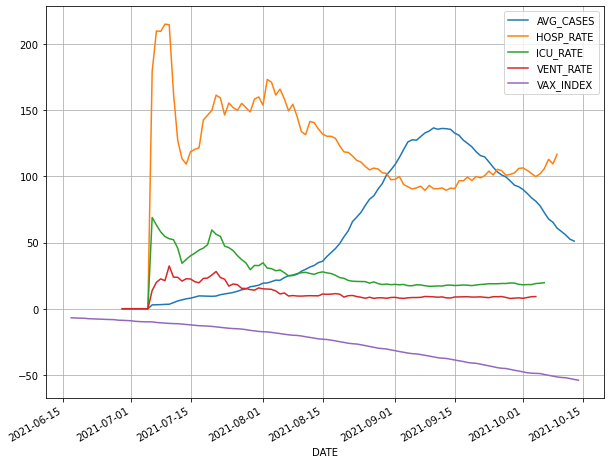

In [95]:
rates = cases_lag[["DATE","AVG_CASES","HOSP_RATE","ICU_RATE","VENT_RATE","AVG_DEATH_RATE","VAX_INDEX"]]
rates = rates[(rates["DATE"]>"2021-06-16")&(rates["DATE"]<"2021-11-01")]
rates["VAX_INDEX"] = rates["VAX_INDEX"]/100000
rates["AVG_CASES"] = rates["AVG_CASES"]/10
rates.plot(
    kind = "line",
    x="DATE",
    y=["AVG_CASES","HOSP_RATE","ICU_RATE","VENT_RATE","VAX_INDEX"],
    figsize = [10,8],
    grid=True
)


<AxesSubplot:xlabel='DATE'>

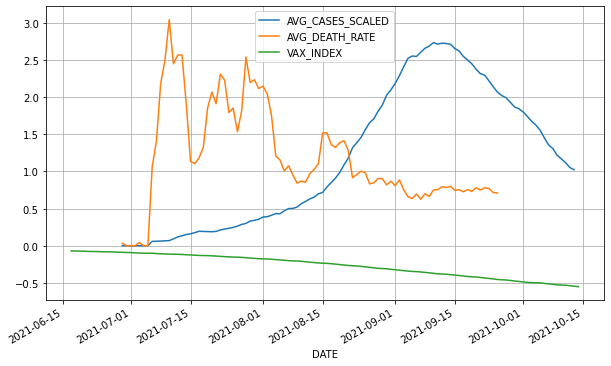

In [210]:
rates = cases_lag[["DATE","AVG_CASES","HOSP_RATE","ICU_RATE","VENT_RATE","AVG_DEATH_RATE","VAX_INDEX"]]
rates = rates[(rates["DATE"]>"2021-06-16")&(rates["DATE"]<"2021-11-01")]
popNSW = 8166000
fullVax = popNSW*1.2
rates["VAX_INDEX"] = rates["VAX_INDEX"]/fullVax
rates["VAX_HOVER"] = round(rates["VAX_INDEX"]*-100,2)
rates["AVG_CASES_SCALED"] = rates["AVG_CASES"]/500
rates.plot(
    kind = "line",
    x="DATE",
    y=["AVG_CASES_SCALED","AVG_DEATH_RATE","VAX_INDEX"],
    figsize = [10,6],
    grid=True
)


In [215]:
fig=px.line(
    rates,
    x="DATE",
    y="AVG_DEATH_RATE",
    title='7 day average death rate',
    color_discrete_sequence=["orange"],
    labels={"DATE":"Date","AVG_DEATH_RATE":"Death Rate (%)"}
)

fig.add_trace(px.area(
    rates, 
    x="DATE",
    y="AVG_CASES_SCALED", 
    labels={"DATE":"Date","AVG_CASES":"Cases"},
    hover_data={"AVG_CASES":True,"AVG_CASES_SCALED":False},
    color_discrete_sequence=["powderblue"]).data[0]
)
          
    
fig.add_trace(px.bar(
    rates,x="DATE",
    y="VAX_INDEX",
    labels={"DATE":"Date","VAX_INDEX":"Vaccination Level (%)","VAX_HOVER":"Vaccination Level (%)"},
    hover_data={"VAX_INDEX":False,"VAX_HOVER":True},
    color_discrete_sequence=["plum"]).data[0],
)
              
fig.show()